Can we tell if a machine with 20 noisy qubits is better than one with 5 very high-quality qubits? Or if a machine with 8 fully-connected qubits is better than one with 16 qubits of comparable error rate, but arranged in a square lattice? How can we make comparisons between different types of qubits?  

To compare across all these facets, researchers have proposed a metric called “quantum volume”. Roughly, the quantum volume is a measure of the effective number of qubits a processor has. It is calculated by determining the largest number of qubits on which it can reliably run circuits of a prescribed type.  

After working through this tutorial, you’ll be able to define quantum volume, explain the problem on which it’s based, and run the protocol to compute it!

## Designing a benchmark for quantum computers  
There are many different properties of a quantum computer that contribute to the successful execution of a computation. Therefore, we must be very explicit about what exactly we are benchmarking, and what is our measure of success. In general, to set up a benchmark for a quantum computer we need to decide on a number of things:

1. A family of circuits with a well-defined structure and variable size
2. A set of rules detailing how the circuits can be compiled
3. A measure of success for individual circuits
4. A measure of success for the family of circuits
5. (Optional) An experimental design specifying how the circuits are to be run  

We'll work through this list in order to see how the protocol for computing quantum volume fits within this framework

### The circuits  
Quantum volume relates to the largest *square* circuit that a quatum processor can run reliably. This benchmark uses *random* square circuits with a very particular form:  
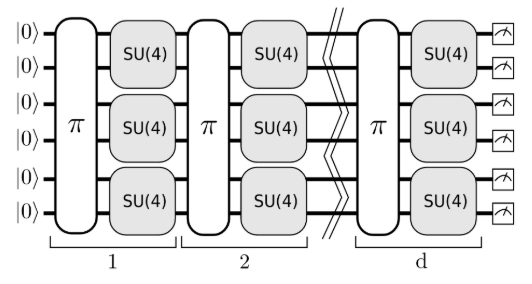  
Specifically, the circuits consist of $d$ sequential layers acting on $d$ qubits. 각 layer는 random permutation 층과 이웃한 큐비트와의 Haar-random SU(4) 연산으로 구성(큐비트수가 홀수면 마지막은 idle). 이 회로는 위의 1번 (well-defined and variable size) 충족  

규칙 2번에 관해서는,양자 볼륨 계산을 위해 본질적으로 어떤 것도 가능. optimization, hardware-aware considerations such as qubit placement and routing, and even resynthesis by finding unitaries that are close to the target, but easier to implement on the hardware.  

오류 확류은 achievalbe depth에 영햐을 주고, qubit connectivity는 layers of permutations에 영향을 줌. 왜냐하면 well-connected processor는 less-connected one보다 더 빠르게 implement할 수 있기 때문. compiler와 software도 중요한 역할을 함: 고성능 컴파일러는 target device에 더욱 fit한 회로를 만들 것 ==> 고퀄 결과  


### The measure of success  
We have to define the quantities that will indicate how well we're able to run circuits. For that, we need a problem to solve. The problem used for computing quantum volume is called the *heavy output generation problem*. It has roots in the proposals for demonstrating quantum advatage. Many such proposals make use of the properties of various random quantum ircuit families, as the distribution of the measurement outcomes may not be easy to sample using calssical techniques  

A distribution that is theorized to fulfill this property is the distribution of *heavy* output bit strings. Heavy bit strings are those whose outcome probabilies are above the median of the distribution. For example, we run a two-qubit circuit and find that the measurement probabilies for the output states are as follows:  

In [2]:
measurement_probs = {"00": 0.558, "01": 0.182, "10": 0.234, "11": 0.026}

The median of this prob dist is:

In [18]:
import numpy as np

prob_array = np.fromiter(measurement_probs.values(), dtype = np.float64)
# fromiter: 반복 가능(iterable)한 객체(리스트, 제너레이터 등)로부터 numpy 1차원 배열을 생성하는 함수
print(f"Median = {np.median(prob_array):.3f}")

Median = 0.208


This means that the heavy bit strings are ‘00’ and ‘10’, because these are the two probabilities above the median. If we were to run this circuit, the probability of obtaining one of the heavy outputs is:

In [20]:
heavy_output_prob = np.sum(prob_array[prob_array > np.median(prob_array)])
print(f"Heavy output probability = {heavy_output_prob}")

Heavy output probability = 0.792


Each circuit in a circuit family has its own heavy output probability. If our quantum computer is of high quality, then we should expect to see heavy outputs quite often across all the circuits. On the other hand, if it’s of poor quality and everything is totally decohered, we will end up with output probabilities that are roughly all the same, as noise will reduce the probabilities to the uniform distribution.  

The heavy output generation problem quantifies this — for our family of random circuits, do we obtain heavy outputs at least 2/3 of the time on average? Furthermore, do we obtain this with high confidence? This is the basis for quantum volume. Looking back at the criteria for our benchmarks, for item 3 the measure of success for each circuit is how often we obtain heavy outputs when we run the circuit and take a measurement. For item 4 the measure of success for the whole family is whether or not the mean of these probabilities is greater than 2/3 with high confidence.  

On a related note, it is important to determine what heavy output prob we sholud *expect* to see on average. Suppose our random square circuits scramble things up enough so taht the effective operation looks like a Haar-random unitary $U$. Since in the circuits we are applying $U$ to the all-zero ket, the measurement outcome probs will be the moduli squared of the entries in the first column of $U$  
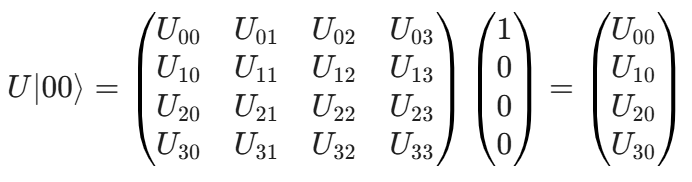  

Now if $U$ is Haar-random, we can say something about the form of these entries. In particular, they are complex numbers for which both the real and imaginary parts are normally distributed with mean 0 and variance $1/2^m$, wehre $m$ is the number of qubits. Taking the modulus squared of such numbers and making a histogram yields a distribution of probabilities with the form $Pr(p)~2^m e^{-2^{m}p}$. This is also known as the *Porter-Thomas distribution*.  

By looking at the form of the underlying probability distribution, the exponential distribution $Pr(x) = e^{-x}$, we can calculate some properties of the heavy output probabilities. First, we can integrate the exponential distribution to find that the median sits at $ln2$. we can further compute the expectation value of obtaining something greather than the median by integrating $xe^{-x}$ from $ln2$ to $\inf$ to obtain $\frac{1+ln2}/{2}$. This is the expected heavy output probability!. Numerically it is around 0.85, as we will observe later in our results. 

정리: Noise-free 무작위 양자 회로(Haar-random)를 측정했을 때 "Heavy Bitstring"이 나올 확률의 총합은 통계적으로 약 85%이다.

### The benchmark  
Note that we have our circuits and our measures of success, we're ready to define the quantum volume.  

**Definition**  
The quantum volumne $V_Q$ of an $n$-qubit processor is defined as  
$$\log_{2}{V_Q}=argmax_{m}min(m,d(m))$$
where $m <= n$ is a number of qubits, and $d(m)$ is the number of qubits in the largest square circuits for which we can reliably sample heavy outputs with probability greater than 2/3  

To see this more concretle,y suppose we have 20-qubit device and find that we get heavy outputs reliably for up to depth-4 circuits on any set of 4 qubitsm then the quantum volumne is $\log_2V_Q=4$. Quantum volume is incremental, as shown velow - gradually work our way up to larget circuits, until we find something we can't do. Very loosely, quantum volume is like an effective number of qubits. Even if we have those 20 qubits, only groups of up to 4 of them work well enough together to sample from distributions that would be considered hard  
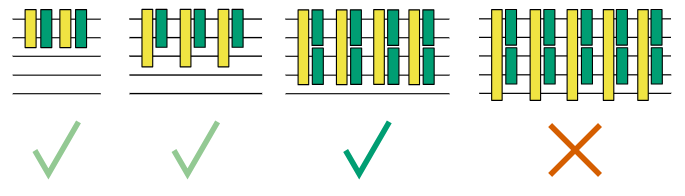  

다시 말해, 양자 볼륨은 오류 없이 완벽하게 돌릴 수 있는 가장 큰 정사각형 모양의 회로 규모를 의미함

## Computing the quantum volume  
이제 실제로 양자 볼륨을 계산해 볼 차례인데, ```PennyLane-Qiskit``` 을 사용하겠음.  

Loosely, the protocol for quantum volume consists of three steps  
1. Construct random wquare circuits of increasing size
2. Run those circuits on both a simulator and on a noisy hardware device
3. Perfomr a statistical analysis of the results to determine what size circuits the device can run reliably  

The largest reliable size will become the $m$ in the expression for quantum volume

### Step 1: Construct random square circuits  
random permutation과 SU(4)를 구현하자

In [45]:
import pennylane as qml

# Object for random number generation from numpy
rng = np.random.default_rng()

def permute_qubits(n_qubits):
    perm_order = list(rng.permutation(n_qubits))
    qml.Permute(perm_order, wires = list(range(n_qubits)))

from scipy.stats import unitary_group

def apply_random_su4(n_qubits):
    for q in range(0, n_qubits, 2):
        if q < n_qubits - 1:
            random_haar_su4 = unitary_group.rvs(4) # 4x4 유니터리 행렬을 하르 분포(Haar distribution)를 따르도록 무작위 생성
            qml.QubitUnitary(random_haar_su4, wires = [q, q+1])

def qv_circuit_layer(n_qubits):
    permute_qubits(n_qubits)
    apply_random_su4(n_qubits)

Let’s take a look! We’ll set up an ideal device with 5 qubits, and generate a circuit with 3 qubits. In this demo, we’ll work explicitly with **quantum tapes** since they are not immediately tied to a device. This will be convenient later when we need to run the same random circuit on two devices independently.

In [50]:
num_qubits = 5
dev_ideal = qml.device('lightning.qubit', shots = None, wires = num_qubits)

m = 3 # number of qubits

with qml.tape.QuantumTape() as tape:
    for _ in range(m):
        qv_circuit_layer(m)
    
(expanded_tape,), _ = qml.transforms.decompose(tape, gate_set={qml.QubitUnitary, qml.SWAP})
print(qml.drawer.tape_text(expanded_tape, 
                           wire_order=dev_ideal.wires, 
                           show_all_wires=True, 
                           show_matrices=True))

0: ─╭SWAP───────╭U(M0)─╭U(M1)─╭SWAP───────╭U(M2)─┤  
1: ─│─────╭SWAP─╰U(M0)─╰U(M1)─│─────╭SWAP─╰U(M2)─┤  
2: ─╰SWAP─╰SWAP───────────────╰SWAP─╰SWAP────────┤  
3: ──────────────────────────────────────────────┤  
4: ──────────────────────────────────────────────┤  
M0 = 
[[ 0.34125337+0.3129572j  -0.08030688-0.29468839j  0.06128017-0.0843835j
   0.31072258-0.76478044j]
 [-0.26717088+0.57747755j  0.25554866-0.46385276j -0.23825033-0.01908521j
  -0.50533832+0.04669697j]
 [-0.31964236-0.02435501j -0.52158572+0.02536319j -0.74689261-0.14097504j
   0.20524574-0.06850028j]
 [ 0.52461095-0.05255733j  0.56933488+0.17148728j -0.5689784 -0.17475052j
   0.07638654+0.09144353j]]
M1 = 
[[ 0.33297899+0.05472694j -0.02960838-0.22062871j -0.17885937+0.28952473j
   0.63410832+0.56450657j]
 [ 0.09529802-0.52641562j -0.35497048+0.67806207j -0.02158387+0.00429005j
  -0.09883159+0.34319196j]
 [-0.41027898+0.11615921j -0.42388011-0.01158635j -0.54543116-0.49184674j
   0.30824444-0.0628221j ]
 [ 0.19261502+0.

The first thing to note is that the last two qubits are never used in the operations, since the quantum volume circuits are square. Another important point is that this circuit with 3 layers actually has depth much greater than 3, since each layer has both SWAPs and SU(4) operations that are further decomposed into elementary gates when run on the actual processor.

One last thing we’ll need before running our circuits is the machinery to determine the heavy outputs. This is quite an interesting aspect of the protocol — we’re required to compute the heavy outputs classically in order to get the results! As a consequence, it will only be possible to calculate quantum volume for processors up to a certain point before they become too large.

That said, classical simulators are always improving, and can simulate circuits with numbers of qubits well into the double digits (though they may need a supercomputer to do so). Furthermore, the designers of the protocol don’t expect this to be an issue until gate error rates decrease below $~10^{-4}$, after which we may need to make adjustments to remove the classical simulation, or even consider new volume metrics  

The heavy outputs can be retrieved from a classically-obtained prob dist as follows:

In [51]:
def heavy_output_set(m, probs):
    probs_ascending_order= np.argsort(probs)
    sorted_probs = probs[probs_ascending_order]

    # Heavy outputs are the bit stirngs above median 
    heavy_outputs = [
        # Convert integer indices to m-bit binary strings
        format(x, f"#0{m+2}b")[2:] for x in list(probs_ascending_order[2**(m-1):])
        # 2**(m-1)로 median 이상의 인덱스들을 추출했고, 
        # f-string 속 #은 이진수 앞에 0b 접두사를 붙이라는 뜻이고,
        # 0은 숫자가 지정된 길이보다 짧으면 0으로 채우라는 뜻
        # 여기서 m = 3이므로 전체 길이는 m+2인 5임
        # 만약 x가 1이라면 1의 이지수는 0b1이며, 길이를 5로 맞추기 위해 0b001로 변환됨
        # [2:]는 접두사 0b를 제거하기 위함
    ]

    # Prob of a heavy output
    prob_heavy_output = np.sum(sorted_probs[2**(m-1):])

    return heavy_outputs, prob_heavy_output

In [59]:
# Adds a measurement of the first m qubits to the previous circuit
tape = tape.copy(measurements=[qml.probs(wires=range(m))])

# Run the circuit, compute heavy outputs, and print results
[output_probs] = qml.execute([tape], dev_ideal)  # returns a list of result !
output_probs = output_probs.reshape(2**m)
heavy_outputs, prob_heavy_output = heavy_output_set(m, output_probs)

print("State\tProbability")
for idx, prob in enumerate(output_probs):
    bit_string = format(idx, f"#05b")[2:]
    print(f"{bit_string}\t{prob:.4f}")

print(f"\nMedian is {np.median(output_probs):.4f}")
print(f"Probability of a heavy output is {prob_heavy_output:.4f}")
print(f"Heavy outputs are {heavy_outputs}")

State	Probability
000	0.1380
001	0.0808
010	0.0600
011	0.0197
100	0.0159
101	0.0467
110	0.4483
111	0.1906

Median is 0.0704
Probability of a heavy output is 0.8577
Heavy outputs are ['001', '000', '111', '110']


### Step 2: run the circuits  
Now it's time to run the protocol. First, let's set up our hardware device. We'll use a simulated version of the 5-qubit IBM Lima as an example - the reported quantum volume is $V_Q = 8$, sowe endevour to reproduce that here. This means that we should be able to run our square circuits reliably on up to $\log_{2}{V_Q}=3$ qubits

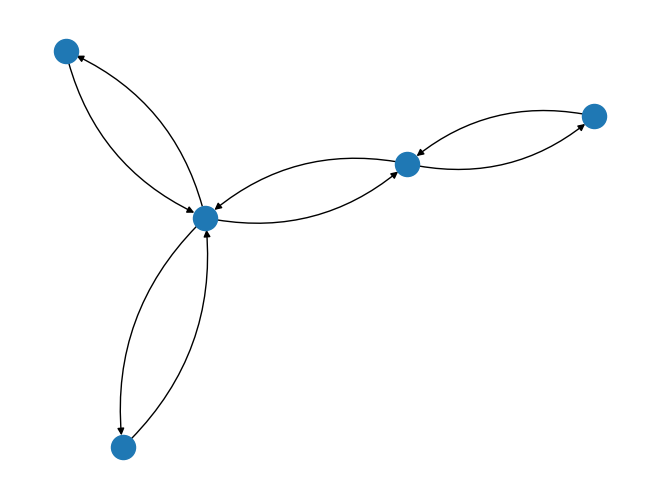

In [63]:
from rustworkx.visualization import mpl_draw
from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from matplotlib import pyplot as plt

mpl_draw(FakeLimaV2().coupling_map.graph)
plt.show()

This hardware graph is not fully connected, so the quantum compiler will have to make some adjustments when non-connected qubits need to interact.

To actually perform the simulations, we’ll need to access a copy of the Lima noise model. Again, we won’t be running on Lima directly — we’ll set up a local device to simulate its behaviour.

As a final point, since we are allowed to do as much optimization as we like, let’s put the compiler to work. The compiler will perform a number of optimizations to simplify our circuit. We’ll also specify some high-quality qubit placement and routing techniques [10] in order to fit the circuits on the hardware graph in the best way possible.

In [66]:
transpile_args = {
    "optimization_level": 3,
    "coupling_map": FakeLimaV2().coupling_map,
    "layout_method": "sabre",
    "routing_method": "sabre",
}

dev_noisy = qml.device("qiskit.remote", wires=5, backend=FakeLimaV2(), **transpile_args)

In [67]:
min_m = 2
max_m = 5
num_ms = (max_m - min_m) + 1

num_trials = 200

# To store the results
probs_ideal = np.zeros((num_ms, num_trials))
probs_noisy = np.zeros((num_ms, num_trials))

for m in range(min_m, max_m + 1):
    for trial in range(num_trials):

        # Simulate the circuit analytically
        with qml.tape.QuantumTape() as tape_probs:
            for _ in range(m):
                qv_circuit_layer(m)
            qml.probs(wires=range(m))

        # when using qml.execute, shots must be on the tape
        tape_counts = tape_probs.copy(measurements=[qml.counts()], shots=1000)

        output_probs = qml.execute([tape_probs], dev_ideal)
        output_probs = output_probs[0].reshape(2**m)
        heavy_outputs, prob_heavy_output = heavy_output_set(m, output_probs)

        # Execute circuit on the noisy device
        [counts] = qml.execute([tape_counts], dev_noisy)

        device_heavy_outputs = np.sum(
            [counts[x] if x[:m] in heavy_outputs else 0 for x in counts.keys()]
        )
        fraction_device_heavy_output = device_heavy_outputs / tape_counts.shots.total_shots

        probs_ideal[m - min_m, trial] = prob_heavy_output
        probs_noisy[m - min_m, trial] = fraction_device_heavy_output

/home/ubuntu/miniconda3/envs/lqgan/lib/python3.11/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
/home/ubuntu/miniconda3/envs/lqgan/lib/python3.11/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
/home/ubuntu/miniconda3/envs/lqgan/lib/python3.11/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
/home/ubuntu/miniconda3/envs/lqgan/lib/python3.11/site-packages/qiskit/compiler/tr

### Step 3: perform a statistical analysis  
Having run our experiments, we can now get to the heart of the quantum volume protocol: what is the largest square circuit that our processor can run? Let’s first check out the means and see how much higher they are than 2/3.

In [68]:
probs_mean_ideal = np.mean(probs_ideal, axis=1)
probs_mean_noisy = np.mean(probs_noisy, axis=1)

print(f"Ideal mean probabilities:")
for idx, prob in enumerate(probs_mean_ideal):
    print(f"m = {idx + min_m}: {prob:.6f} {'above' if prob > 2/3 else 'below'} threshold.")

print(f"\nDevice mean probabilities:")
for idx, prob in enumerate(probs_mean_noisy):
    print(f"m = {idx + min_m}: {prob:.6f} {'above' if prob > 2/3 else 'below'} threshold.")

Ideal mean probabilities:
m = 2: 0.794801 above threshold.
m = 3: 0.851165 above threshold.
m = 4: 0.841283 above threshold.
m = 5: 0.854881 above threshold.

Device mean probabilities:
m = 2: 0.754995 above threshold.
m = 3: 0.802155 above threshold.
m = 4: 0.711875 above threshold.
m = 5: 0.711665 above threshold.


In [70]:
stds_ideal = np.sqrt(probs_mean_ideal * (1 - probs_mean_ideal) / num_trials)
stds_noisy = np.sqrt(probs_mean_noisy * (1 - probs_mean_noisy) / num_trials)

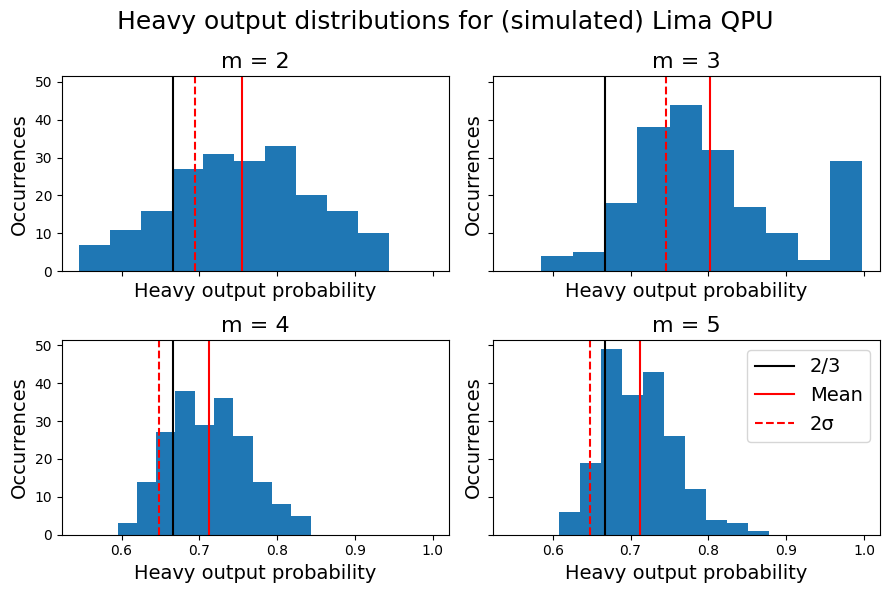

In [71]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 6))
ax = ax.ravel()

for m in range(min_m - 2, max_m + 1 - 2):
    ax[m].hist(probs_noisy[m, :])
    ax[m].set_title(f"m = {m + min_m}", fontsize=16)
    ax[m].set_xlabel("Heavy output probability", fontsize=14)
    ax[m].set_ylabel("Occurrences", fontsize=14)
    ax[m].axvline(x=2.0 / 3, color="black", label="2/3")
    ax[m].axvline(x=probs_mean_noisy[m], color="red", label="Mean")
    ax[m].axvline(
        x=(probs_mean_noisy[m] - 2 * stds_noisy[m]),
        color="red",
        linestyle="dashed",
        label="2σ",
    )

fig.suptitle("Heavy output distributions for (simulated) Lima QPU", fontsize=18)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [73]:
two_sigma_below = probs_mean_noisy - 2 * stds_noisy

for idx, prob in enumerate(two_sigma_below):
    print(f"m = {idx + min_m}: {prob:.6f} {'above' if prob > 2/3 else 'below'} threshold.")

m = 2: 0.694171 above threshold.
m = 3: 0.745816 above threshold.
m = 4: 0.647827 below threshold.
m = 5: 0.647603 below threshold.
